In [1]:
#!/usr/bin/env python3

"""
Connect to PX4 flight controller and send 25 Hz GUIDED position+velocity targets
to track a reference trajectory defined in the vehicle's local NED frame.
Uses SET_POSITION_TARGET_LOCAL_NED.

Ref trajectory demo: level circle of radius 100 m at 5 m AGL (z = -5 NED).

Run command: python px4_waypoint_follow.py --conn udpin:0.0.0.0:14550 --duration 20
"""

import argparse
import math
import sys
import time
from dataclasses import dataclass
from typing import Tuple, Optional, List, Union
import numpy as np

from pymavlink import mavutil


@dataclass
class LocalNED:
    x: float
    y: float
    z: float  # NED: down is positive


@dataclass
class PlanState:
    pos: LocalNED
    yaw_deg: float  # Heading in degrees
    vel: float
    t: float


# ----------------------------
# Trajectory Interpolation
# ----------------------------


def _angle_lerp_deg(a_deg: float, b_deg: float, alpha: float) -> float:
    """
    Interpolate angles (degrees) along the shortest arc.
    Returns an angle in the same wrap as 'a_deg' plus delta.
    """
    # Smallest signed difference in degrees, range (-180, 180]
    diff = math.remainder(b_deg - a_deg, 360.0)
    return a_deg + alpha * diff


def interpolate_plan_state(states: List[PlanState], interp_t: float) -> PlanState:
    """
    Interpolate a sparse trajectory (states) at trajectory time 'interp_t'.

    Args:
        states: non-empty, typically sorted by increasing .t
        current_pos: current vehicle position (unused in this pure time-based interp,
                     but kept for API parity/future snap-to-trajectory logic)
        interp_t: trajectory-relative time in seconds (same timebase as states[].t)

    Returns:
        PlanState at time interp_t (position, yaw, speed, t)

    Notes:
        - If interp_t is before the first state, returns the first state.
        - If after the last state, returns the last state.
        - Yaw is blended via shortest-arc interpolation in degrees.
        - Position and speed are linearly interpolated.
    """
    if not states:
        raise ValueError("interpolate_plan_state: 'states' must be non-empty")

    # Ensure monotonic order by time; if not guaranteed, sort a shallow copy.
    if any(states[i].t > states[i + 1].t for i in range(len(states) - 1)):
        states = sorted(states, key=lambda s: s.t)

    # Find first state with t >= interp_t (Python's equivalent of lower_bound)
    upper_idx = None
    lo, hi = 0, len(states) - 1
    # Binary search for efficiency on long trajectories
    while lo <= hi:
        mid = (lo + hi) // 2
        if states[mid].t < interp_t:
            lo = mid + 1
        else:
            upper_idx = mid
            hi = mid - 1

    if upper_idx is None:
        # interp_t beyond last point -> clamp to last
        lower_idx = len(states) - 1
        upper_idx = lower_idx
    elif upper_idx == 0 or states[upper_idx].t == interp_t:
        # at/before first point or exact hit
        lower_idx = upper_idx
    else:
        lower_idx = upper_idx - 1

    lower = states[lower_idx]
    upper = states[upper_idx]

    # Alpha in [0,1]
    alpha = 0.0
    if upper is not lower:
        dt = upper.t - lower.t
        if dt > 0.0:
            alpha = max(0.0, min(1.0, (interp_t - lower.t) / dt))

    # LERP helpers
    def lerp(a: float, b: float) -> float:
        return a + alpha * (b - a)

    # Position (LocalNED)
    x = lerp(lower.pos.x, upper.pos.x)
    y = lerp(lower.pos.y, upper.pos.y)
    z = lerp(lower.pos.z, upper.pos.z)

    # Yaw (degrees, shortest arc)
    yaw_deg = _angle_lerp_deg(lower.yaw_deg, upper.yaw_deg, alpha)

    # Speed
    vel = lerp(lower.vel, upper.vel)

    return PlanState(LocalNED(x, y, z), yaw_deg, vel, interp_t)


def compute_lookahead_velocity(
    states: List[PlanState],
    current_position: LocalNED,
    ts: float,  # lookahead time on the trajectory timebase
    now_s: Optional[
        float
    ] = None,  # wall/monotonic time used only if we substitute the lower state
) -> LocalNED:
    """
    Compute constant-segment lookahead velocity at trajectory time 'ts' from a sparse set of PlanStates.

    Behavior matches the C++ reference:
      - We find 'upper' = first state with t >= ts (lower_bound).
      - If ts is after the last state, we use the last two states.
      - If ts is at/before the first state's time (or exactly equal), we substitute the 'lower' state
        with the *current vehicle pose* (current_position) and time 'now_s'.
      - The velocity is direction * magnitude, where direction is the normalized delta between
        lower and upper positions, and magnitude = distance / dt.

    Returns:
        LocalNED velocity vector (vx, vy, vz) in m/s. (NED: +z is down)
    """
    if not states:
        raise ValueError("compute_lookahead_velocity: 'states' must be non-empty")

    # Ensure states are sorted by time (stable if already sorted)
    if any(states[i].t > states[i + 1].t for i in range(len(states) - 1)):
        states = sorted(states, key=lambda s: s.t)

    # ------ lower_bound for ts ------
    upper_idx = None
    lo, hi = 0, len(states) - 1
    while lo <= hi:
        mid = (lo + hi) // 2
        if states[mid].t < ts:
            lo = mid + 1
        else:
            upper_idx = mid
            hi = mid - 1

    # If time is > our last state time, use the last two states
    if upper_idx is None:
        upper_idx = len(states) - 1

    # If time is <= first state time OR exactly equals upper.t, lower = current ego pose
    if upper_idx == 0 or states[upper_idx].t == ts:
        lower_pos = current_position
        # In the C++ code, lower.t is set to now_s; we only need it to compute dt,
        # but when upper.t == ts, the dt will be (ts - now_s) which could be <= 0.
        # That matches the reference behavior (magnitude becomes 0 if dt <= 0).
        lower_t = now_s if now_s is not None else states[upper_idx].t
    else:
        lower = states[upper_idx - 1]
        lower_pos = lower.pos
        lower_t = lower.t

    upper = states[upper_idx]
    upper_pos = upper.pos
    upper_t = upper.t

    # Delta in LOCAL_NED
    dx = upper_pos.x - lower_pos.x
    dy = upper_pos.y - lower_pos.y
    dz = upper_pos.z - lower_pos.z

    # Distance and direction
    dist = math.sqrt(dx * dx + dy * dy + dz * dz)
    if dist > 0.0:
        dir_x = dx / dist
        dir_y = dy / dist
        dir_z = dz / dist
    else:
        dir_x = dir_y = dir_z = 0.0

    # Magnitude = distance / dt (dt <= 0 -> 0, as in the C++)
    dt = upper_t - lower_t
    mag = (dist / dt) if dt > 0.0 else 0.0

    return LocalNED(dir_x * mag, dir_y * mag, dir_z * mag)


# ----------------------------
# Velocity Smoother
# ----------------------------


@dataclass
class VelocitySmootherConfig:
    # Exponential smoothing time constants (s); 0 disables EMA for that axis group
    tau_v_xy: float = 0.0
    tau_v_z: float = 0.0

    # Acceleration (slew) limits (m/s^2)
    a_max_xy: float = 2.0
    a_max_up: float = 2.0  # Upward (−z) velocity change limit
    a_max_down: float = 2.0  # Downward (+z) velocity change limit

    # Output velocity limits (m/s)
    v_max_xy: float = 5.0
    v_max_up: float = 2.0  # Max upward speed (−z). z_cmd <= +v_max_up
    v_max_down: float = 2.0  # Max downward speed (+z). z_cmd >= −v_max_down


Vector3Like = Union[LocalNED, tuple[float, float, float], list[float]]


class VelocitySmoother:
    """
    Python reimplementation of the C++ scout::VelocitySmoother.

    Behavior:
      1) First-order exponential smoothing on velocity command
      2) Slew-limit delta v by acceleration caps (XY isotropic, Z asym.)
      3) Clamp final output by XY magnitude and Z up/down limits

    Conventions:
      LOCAL_NED axes with z positive DOWN.
    """

    def __init__(self, config: VelocitySmootherConfig):
        self.config = config
        self._validate_config()
        self.reset()

    def _validate_config(self):
        if self.config.tau_v_xy < 0.0 or self.config.tau_v_z < 0.0:
            raise ValueError("Time constants cannot be negative.")
        if (
            self.config.a_max_xy <= 0.0
            or self.config.a_max_up <= 0.0
            or self.config.a_max_down <= 0.0
        ):
            raise ValueError("Acceleration limits must be strictly positive.")
        if (
            self.config.v_max_xy <= 0.0
            or self.config.v_max_up <= 0.0
            or self.config.v_max_down <= 0.0
        ):
            raise ValueError("Velocity limits must be strictly positive.")

    def reset(self):
        self._last_cmd = LocalNED(0.0, 0.0, 0.0)
        self._last_t = None  # type: Optional[float]

    @staticmethod
    def _to_localned(v: Vector3Like) -> LocalNED:
        if isinstance(v, LocalNED):
            return v
        x, y, z = v  # will raise naturally if not len=3
        return LocalNED(float(x), float(y), float(z))

    def smooth(self, v_desired: Vector3Like, now_s: Optional[float] = None) -> LocalNED:
        """
        Args:
            v_desired: desired velocity (LocalNED or (x,y,z) in m/s)
            now_s: optional timestamp (seconds). Defaults to time.monotonic().
        Returns:
            LocalNED velocity command after smoothing / limiting.
        """
        cfg = self.config
        v_des = self._to_localned(v_desired)
        v_prev = self._last_cmd

        if now_s is None:
            now_s = time.monotonic()

        # Handle first call or time going backwards
        if self._last_t is None:
            self._last_cmd = v_des
            self._last_t = now_s
            return v_des

        dt = now_s - self._last_t
        if dt < 0.0:
            # If clock went backwards, snap to desired and re-time.
            self._last_cmd = v_des
            self._last_t = now_s
            return v_des

        # 1) Exponential smoothing
        def alpha(dt_, tau):
            return 1.0 if tau <= 0.0 else (1.0 - math.exp(-dt_ / tau))

        a_xy = alpha(dt, cfg.tau_v_xy)
        a_z = alpha(dt, cfg.tau_v_z)

        v_cmd_x = v_prev.x + a_xy * (v_des.x - v_prev.x)
        v_cmd_y = v_prev.y + a_xy * (v_des.y - v_prev.y)
        v_cmd_z = v_prev.z + a_z * (v_des.z - v_prev.z)

        # 2) Slew limits (acceleration caps)
        # XY isotropic
        max_d_xy = cfg.a_max_xy * dt
        d_x = v_cmd_x - v_prev.x
        d_y = v_cmd_y - v_prev.y
        d_xy_norm = math.hypot(d_x, d_y)
        if d_xy_norm > max_d_xy > 0.0:
            scale = max_d_xy / d_xy_norm
            d_x *= scale
            d_y *= scale
            v_cmd_x = v_prev.x + d_x
            v_cmd_y = v_prev.y + d_y

        # Z asymmetric (up/down)
        max_d_z_up = cfg.a_max_up * dt  # limiting positive delta (toward +z)
        max_d_z_dn = cfg.a_max_down * dt  # limiting negative delta (toward -z)
        d_z = v_cmd_z - v_prev.z
        if d_z > max_d_z_up:
            v_cmd_z = v_prev.z + max_d_z_up
        elif d_z < -max_d_z_dn:
            v_cmd_z = v_prev.z - max_d_z_dn

        # 3) Output clamps
        # XY magnitude
        v_xy = math.hypot(v_cmd_x, v_cmd_y)
        if v_xy > cfg.v_max_xy and v_xy > 0.0:
            s = cfg.v_max_xy / v_xy
            v_cmd_x *= s
            v_cmd_y *= s

        # Z up/down (remember: +z is DOWN)
        v_cmd_z = min(v_cmd_z, cfg.v_max_up)  # cap upward magnitude (−z)
        v_cmd_z = max(v_cmd_z, -cfg.v_max_down)  # cap downward magnitude (+z)

        out = LocalNED(v_cmd_x, v_cmd_y, v_cmd_z)
        self._last_cmd = out
        self._last_t = now_s
        return out


# ----------------------------
# Trajectory generator
# ----------------------------


# Simplest example
def circle_profile(t, r=1.0, w=0.25):
    """
    Parametric circle in XY with radius r [m] and angular speed w [rad/s].
    Returns pos offsets (dx,dy) and feedforward velocity (vx,vy).
    """
    dx = r * math.cos(w * t)
    dy = r * math.sin(w * t)
    vx = -r * w * math.sin(w * t)
    vy = r * w * math.cos(w * t)
    return dx, dy, vx, vy


def _wrap_deg(a: float) -> float:
    # (-180, 180]
    return (a + 180.0) % 360.0 - 180.0


def generate_zigzag_vertices(
    anchor: LocalNED,
    heading_deg: float,
    segment_length_m: float,
    num_segments: int,
    offset_angle_deg: float,
    speed_ms: float,
    start_with_positive_offset: bool = True,
) -> List[PlanState]:
    """
    Build LOCAL_NED zig-zag vertices around a fixed reference heading.

    Geometry (with ref heading h, offset φ):
      along_step = L * cos(φ)         (advance on the reference centerline each segment)
      lateral    = L * sin(φ)         (perpendicular offset magnitude; sign alternates)
      vertex_k   = anchor + (k * along_step) * ref_dir  +  s_k * lateral * ref_perp
                   where s_k ∈ {+1, -1} alternates each segment

    LOCAL_NED axes: x=N, y=E, z=DOWN (z held constant)
    """
    if num_segments <= 0 or segment_length_m <= 0 or speed_ms <= 0:
        print("invalid inputs: num_segments, segment_length_m, speed_ms must be > 0")
        return []

    # Fixed reference basis
    h = math.radians(heading_deg)
    ref_dir = np.array([math.cos(h), math.sin(h)])  # along reference heading
    ref_perp = np.array([-math.sin(h), math.cos(h)])  # +90° CCW from ref_dir

    # Decompose a length-L step at angle ±offset from the reference
    phi = math.radians(offset_angle_deg)
    along_step = segment_length_m * math.cos(phi)  # on-centerline advance per segment
    lateral_mag = segment_length_m * math.sin(
        phi
    )  # fixed |perp offset| for each vertex

    # timing (constant speed)
    seg_dt = segment_length_m / speed_ms

    # Build vertices
    verts: List[PlanState] = []
    t = 0.0
    x0, y0, z0 = anchor.x, anchor.y, anchor.z
    sign = 1 if start_with_positive_offset else -1

    for k in range(1, num_segments + 1):
        # centerline advance
        center_xy = np.array([x0, y0]) + (k * along_step) * ref_dir
        # alternating lateral displacement
        lateral_xy = (sign if (k % 2 == 1) else -sign) * lateral_mag * ref_perp
        px, py = (center_xy + lateral_xy).tolist()

        # heading for the segment that reaches this vertex is ref ± offset
        seg_heading_deg = _wrap_deg(
            heading_deg
            + (offset_angle_deg if ((k % 2 == 1) == (sign == 1)) else -offset_angle_deg)
        )

        t += seg_dt
        verts.append(PlanState(LocalNED(px, py, z0), seg_heading_deg, speed_ms, t))

    return verts


class SinusoidalTrajectory:
    """
    Local NED (x=north, y=east, z=down) reference that progresses generally north
    while oscillating sinusoidally in Y (east) and Z (vertical) with different
    frequencies. Yaw is aligned with the velocity tangent; psi is yaw rate.

    eval(t) -> ((x, y, z, yaw), (vx, vy, vz, psi))
      - Positions in meters (NED), yaw in radians.
      - Velocities in m/s, psi in rad/s.

    Params:
      v_north_mps   : mean forward speed along +X (north), > 0 keeps tangent well-defined
      y_amp_m       : amplitude of lateral (east) oscillation
      y_freq_hz     : frequency (Hz) of lateral oscillation
      z_mean_m      : mean altitude in NED (down positive; e.g., -5 = 5 m AGL)
      z_amp_m       : amplitude of vertical oscillation (NED)
      z_freq_hz     : frequency (Hz) of vertical oscillation
      x0, y0        : initial NED offsets (meters)
      yaw_offset_rad: constant yaw offset added to tangent (optional)
    """

    def __init__(
        self,
        v_north_mps: float = 5.0,
        y_amp_m: float = 20.0,
        y_freq_hz: float = 0.05,  # 20 s lateral period
        z_mean_m: float = -30.0,  # ~30 m AGL in NED
        z_amp_m: float = 1.0,
        z_freq_hz: float = 0.1,  # 10 s vertical period
        x0: float = 0.0,
        y0: float = 0.0,
        yaw_offset_rad: float = 0.0,
    ):
        import math

        self.math = math
        self.vx = float(v_north_mps)
        self.Ay = float(y_amp_m)
        self.oy = 2.0 * math.pi * float(y_freq_hz)

        self.z_mean = float(z_mean_m)
        self.Az = float(z_amp_m)
        self.oz = 2.0 * math.pi * float(z_freq_hz)

        self.x0 = float(x0)
        self.y0 = float(y0)
        self.yaw_off = float(yaw_offset_rad)

        self._eps = 1e-6  # for safe division in yaw-rate

    def step(self, t: float):
        """Return ((x, y, z, yaw), (vx, vy, vz, psi)) at time t (seconds)."""
        m = self.math

        # Position (NED)
        x = self.x0 + self.vx * t
        y = self.y0 + self.Ay * m.sin(self.oy * t)
        z = self.z_mean + self.Az * m.sin(self.oz * t)

        # Velocity (NED)
        vx = self.vx
        vy = self.Ay * self.oy * m.cos(self.oy * t)
        vz = self.Az * self.oz * m.cos(self.oz * t)

        # Tangent-aligned yaw
        yaw = m.atan2(vy, vx) + self.yaw_off

        # Yaw rate psi = d/dt atan2(vy, vx) = (vx*ay - vy*ax)/(vx^2 + vy^2)
        ax = 0.0
        ay = -self.Ay * (self.oy**2) * m.sin(self.oy * t)
        denom = max(self._eps, (vx * vx + vy * vy))
        psi = (vx * ay - vy * ax) / denom

        return (x, y, z, yaw), (vx, vy, vz, psi)


# ----------------------------
# MAVLink utils
# ----------------------------
def wait_heartbeat(master, timeout=10):
    msg = master.wait_heartbeat(timeout=timeout)
    if not msg:
        raise TimeoutError("No heartbeat received")
    return msg


def wait_local_position(master, timeout=5.0):
    """Wait until we have a LOCAL_POSITION_NED reading."""
    t0 = time.time()
    last = None
    while time.time() - t0 < timeout:
        msg = master.recv_match(type="LOCAL_POSITION_NED", blocking=False)
        if msg:
            last = msg
            break
        time.sleep(0.01)
    if not last:
        raise TimeoutError("No LOCAL_POSITION_NED received (EKF not ready?)")
    return last


def set_mode_ardupilot(master, mode_name):
    """Best-effort mode change for ArduPilot firmwares."""
    mapping = master.mode_mapping() or {}
    if mode_name not in mapping:
        return False
    mode_id = mapping[mode_name]
    master.mav.set_mode_send(
        master.target_system, mavutil.mavlink.MAV_MODE_FLAG_CUSTOM_MODE_ENABLED, mode_id
    )
    return True


def try_enter_guided_or_offboard(master, autopilot):
    """
    For PX4: try to enter OFFBOARD after a short burst of setpoints (PX4 requires it).
    For ArduPilot: enter GUIDED.
    Returns a tuple (target_mode_str, success_bool).
    """
    if autopilot == mavutil.mavlink.MAV_AUTOPILOT_PX4:
        # PX4 OFFBOARD: there's no reliable string mapping via pymavlink, so we:
        # 1) Send a brief pre-stream of setpoints (handled by caller).
        # 2) Attempt MAV_CMD_DO_SET_MODE with OFFBOARD main-mode (PX4-specific).
        # If that fails, we ask the human to toggle to OFFBOARD manually.
        # PX4 encodes modes in a PX4-specific way; we try the common path first:
        PX4_CUSTOM_MAIN_MODE_OFFBOARD = 6  # PX4 enum value
        try:
            master.mav.command_long_send(
                master.target_system,
                master.target_component,
                mavutil.mavlink.MAV_CMD_DO_SET_MODE,
                0,
                mavutil.mavlink.MAV_MODE_FLAG_CUSTOM_MODE_ENABLED,  # param1: base mode flag to enable custom
                PX4_CUSTOM_MAIN_MODE_OFFBOARD,  # param2: PX4 main mode (OFFBOARD)
                0,
                0,
                0,
                0,
                0,
            )
            return ("OFFBOARD", True)
        except Exception:
            return ("OFFBOARD", False)

    elif autopilot == mavutil.mavlink.MAV_AUTOPILOT_ARDUPILOTMEGA:
        ok = set_mode_ardupilot(master, "GUIDED")
        return ("GUIDED", ok)

    else:
        return ("UNKNOWN", False)


def try_enter_hold_or_loiter(master, autopilot):
    """Attempt to return to a pause/hover mode (PX4 HOLD or Ardu LOITER/BRAKE)."""
    try:
        if autopilot == mavutil.mavlink.MAV_AUTOPILOT_PX4:
            # Try PX4 HOLD (pause)
            PX4_CUSTOM_MAIN_MODE_AUTO = 4  # PX4 enum for AUTO
            PX4_CUSTOM_SUB_MODE_AUTO_HOLD = 3
            master.mav.command_long_send(
                master.target_system,
                master.target_component,
                mavutil.mavlink.MAV_CMD_DO_SET_MODE,
                0,
                mavutil.mavlink.MAV_MODE_FLAG_CUSTOM_MODE_ENABLED,
                PX4_CUSTOM_MAIN_MODE_AUTO,  # main mode AUTO
                PX4_CUSTOM_SUB_MODE_AUTO_HOLD,  # sub-mode HOLD
                0,
                0,
                0,
                0,
            )
            return True
        else:
            # ArduPilot: prefer BRAKE (or LOITER as fallback)
            if set_mode_ardupilot(master, "BRAKE"):
                return True
            if set_mode_ardupilot(master, "LOITER"):
                return True
            return False
    except Exception:
        return False


def build_type_mask(
    use_position=True,
    use_velocity=True,
    use_accel=False,
    use_yaw=False,
    use_yaw_rate=False,
):
    """
    POSITION_TARGET_LOCAL_NED.type_mask bitfield:
      - set bit = ignore that field
    We'll keep position+velocity, ignore accel and yaw/yaw_rate by default.
    """
    tm = 0
    # Position (x,y,z)
    if not use_position:
        tm |= (1 << 0) | (1 << 1) | (1 << 2)
    # Velocity (vx,vy,vz)
    if not use_velocity:
        tm |= (1 << 3) | (1 << 4) | (1 << 5)
    # Accel (ax,ay,az)
    if not use_accel:
        tm |= (1 << 6) | (1 << 7) | (1 << 8)
    # Force setpoint bit (rarely used; leave 0)
    # Yaw
    if not use_yaw:
        tm |= 1 << 10
    # Yaw rate
    if not use_yaw_rate:
        tm |= 1 << 11
    return tm


def send_local_ned_setpoint(
    master,
    t_boot_ms,
    x,
    y,
    z,
    vx,
    vy,
    vz,
    yaw=0.0,
    yaw_rate=0.0,
    frame=None,
    type_mask=None,
):
    if frame is None:
        frame = mavutil.mavlink.MAV_FRAME_LOCAL_NED
    if type_mask is None:
        type_mask = build_type_mask(
            use_position=True,
            use_velocity=True,
            use_accel=False,
            use_yaw=False,
            use_yaw_rate=False,
        )

    master.mav.set_position_target_local_ned_send(
        int(t_boot_ms),
        master.target_system,
        master.target_component,
        frame,
        type_mask,
        x,
        y,
        z,
        vx,
        vy,
        vz,
        0.0,
        0.0,
        0.0,  # ax, ay, az (ignored)
        yaw,
        yaw_rate,
    )


# ----------------------------
# UTILS
# ----------------------------


def now_ms(t0):
    return (time.time() - t0) * 1000.0


def parse_args(argv: Optional[List[str]] = None) -> argparse.Namespace:
    """
    Build and parse CLI arguments for the waypoint follower.
    """
    ap = argparse.ArgumentParser(
        description="LOCAL_NED offboard/guided control using POSITION_TARGET_LOCAL_NED"
    )
    ap.add_argument(
        "--conn",
        required=True,
        help="Connection string, e.g. udpin:0.0.0.0:14550 or /dev/ttyUSB0",
    )
    ap.add_argument("--baud", type=int, default=921600, help="Baudrate for serial")
    ap.add_argument(
        "--duration",
        type=float,
        default=60.0,
        help="Duration (s) to run offboard/guided control",
    )
    ap.add_argument(
        "--rate_hz", type=float, default=25.0, help="Setpoint stream rate (Hz)"
    )
    # ap.add_argument(
    #     "--radius_m", type=float, default=25.0, help="Radius for circle profile (m)"
    # )
    # ap.add_argument(
    #     "--omega", type=float, default=0.1, help="Angular rate for circle (rad/s)"
    # )
    return ap.parse_args(argv)


def setup_mode_change(
    master,
    autopilot,
    anchor: LocalNED,
    rate_hz: float,
):
    """
    Pre-stream setpoints, attempt the OFFBOARD/GUIDED transition, and return timing context.
    """
    print("[INFO] Pre-streaming setpoints...")
    t0 = time.time()
    type_mask = build_type_mask(
        use_position=True,
        use_velocity=True,
        use_accel=False,
        use_yaw=False,
        use_yaw_rate=False,
    )
    dt = 1.0 / rate_hz
    prestream_time = 1.5  # seconds
    while (time.time() - t0) < prestream_time:
        t = time.time() - t0
        dx, dy, vx, vy = circle_profile(
            t, r=0.0, w=0.0
        )  # zero motion while pre-streaming
        send_local_ned_setpoint(
            master,
            t_boot_ms=now_ms(t0),
            x=anchor.x + dx,
            y=anchor.y + dy,
            z=anchor.z,  # hold altitude (remember: NED z is down)
            vx=0.0,
            vy=0.0,
            vz=0.0,
            yaw=0.0,
            yaw_rate=0.0,
            frame=mavutil.mavlink.MAV_FRAME_LOCAL_NED,
            type_mask=type_mask,
        )
        time.sleep(dt)

    # Try to switch mode
    target_mode, mode_ok = try_enter_guided_or_offboard(master, autopilot)
    if mode_ok:
        print(f"[INFO] Requested {target_mode} mode.")
    else:
        print(
            f"[WARN] Automatic switch to {target_mode} failed or unsupported on this stack."
        )
        print(
            "       Please toggle the vehicle to OFFBOARD/GUIDED manually as a fallback."
        )
        # Give the pilot a moment to switch while we keep streaming setpoints
        t_wait = time.time()
        while time.time() - t_wait < 5.0:
            # keep sending stationary setpoints so PX4 can accept OFFBOARD when switched
            send_local_ned_setpoint(
                master,
                t_boot_ms=now_ms(t0),
                x=anchor.x,
                y=anchor.y,
                z=anchor.z,
                vx=0.0,
                vy=0.0,
                vz=0.0,
                yaw=0.0,
                yaw_rate=0.0,
                frame=mavutil.mavlink.MAV_FRAME_LOCAL_NED,
                type_mask=type_mask,
            )
            time.sleep(dt)

    return t0, type_mask, dt


# ----------------------------
# Main
# ----------------------------
def main(argv: Optional[List[str]] = None):
    args = parse_args(argv)

    # Connect
    if args.conn.startswith("udp") or args.conn.startswith("tcp"):
        master = mavutil.mavlink_connection(args.conn)
    else:
        master = mavutil.mavlink_connection(args.conn, baud=args.baud)

    print("[INFO] Waiting for heartbeat...")
    hb = wait_heartbeat(master, timeout=15)
    autopilot = getattr(hb, "autopilot", mavutil.mavlink.MAV_AUTOPILOT_GENERIC)
    print(
        f"[INFO] Heartbeat OK. Autopilot: {autopilot} (PX4={mavutil.mavlink.MAV_AUTOPILOT_PX4}, Ardu={mavutil.mavlink.MAV_AUTOPILOT_ARDUPILOTMEGA})"
    )

    # Ensure we have local position
    lp = wait_local_position(master, timeout=10.0)
    anchor = LocalNED(lp.x, lp.y, lp.z)
    print(
        f"[INFO] Anchor (LOCAL_NED): x={anchor.x:.2f}, y={anchor.y:.2f}, z={anchor.z:.2f}"
    )

    # ------------------------ Setup for offboard/guided control -----------------------------
    t0, type_mask, dt = setup_mode_change(
        master,
        autopilot,
        anchor,
        args.rate_hz,
    )

    # ------------------------ Generate reference trajectories ---------------
    des_yaw_deg = 90  # TODO - make an arg
    des_speed_m_s = 3

    # Zigzag
    zigzag_traj = generate_zigzag_vertices(
        anchor=anchor,
        heading_deg=des_yaw_deg,
        segment_length_m=20,
        num_segments=6,
        offset_angle_deg=45,
        speed_ms=des_speed_m_s,
    )
    vel_smoother_config = VelocitySmootherConfig(
        tau_v_xy=0.2,
        tau_v_z=0.2,
        v_max_xy=15,
        v_max_up=4,
        v_max_down=4,
        a_max_xy=3.5,
        a_max_up=2.5,
        a_max_down=2.0,
    )
    vel_smoother = VelocitySmoother(vel_smoother_config)

    # ------------------------ Main control loop -----------------------------
    print(
        f"[INFO] Executing local NED mixed pos+vel profile for {args.duration:.1f}s …"
    )
    t_start = time.time()
    while (time.time() - t_start) < args.duration:
        t = time.time() - t_start

        # Get position along the planned trajectory for point t
        # # Case 1: Circle profile, no smoothing
        # dx, dy, vx, vy = circle_profile(t, r=25.0, w=0.1)
        # x, y, z = anchor.x + dx, anchor.y + dy, anchor.z
        # yaw_rad = 0.0
        # vx, vy, vz = 0.0, 0.0, 0.0

        # Case 2: Sparse zig-zag trajectory with smoothing + limits
        looahead_s = 0.5
        interp_plan_state = interpolate_plan_state(zigzag_traj, t)
        vel_plan = compute_lookahead_velocity(
            zigzag_traj, anchor, ts=t + looahead_s, now_s=t
        )
        vel_smooth = vel_smoother.smooth(v_desired=vel_plan)
        pos = interp_plan_state.pos
        x, y, z = pos.x, pos.y, pos.z
        yaw_rad = np.deg2rad(interp_plan_state.yaw_deg)
        vx, vy, vz = vel_smooth.x, vel_smooth.y, vel_smooth.z

        # Case 3: Sinusoidal trajectory tracking with smoothing + limits
        # TODO

        # Generate control output via mavlink

        send_local_ned_setpoint(
            master,
            t_boot_ms=now_ms(t0),
            x=x,
            y=y,
            z=z,
            vx=vx,
            vy=vy,
            vz=vz,
            yaw=yaw_rad,
            yaw_rate=0.0,
            frame=mavutil.mavlink.MAV_FRAME_LOCAL_NED,
            type_mask=type_mask,
        )
        time.sleep(dt)

    print("[INFO] Attempting to return to Pause/Hold …")
    hold_ok = try_enter_hold_or_loiter(master, autopilot)
    if not hold_ok:
        print(
            "[WARN] Could not auto-switch to a Pause/Hold mode. Releasing control by stopping setpoints."
        )
        # Send a few zero-velocity, current-position setpoints, then stop.
        for _ in range(int(1.0 / dt)):
            send_local_ned_setpoint(
                master,
                t_boot_ms=now_ms(t0),
                x=anchor.x,
                y=anchor.y,
                z=anchor.z,
                vx=vx,
                vy=vy,
                vz=vz,
                yaw=0.0,
                yaw_rate=0.0,
                frame=mavutil.mavlink.MAV_FRAME_LOCAL_NED,
                type_mask=type_mask,
            )
            time.sleep(dt)

    print("[INFO] Control complete. Pilot may take back control and land manually.")
    master.close()




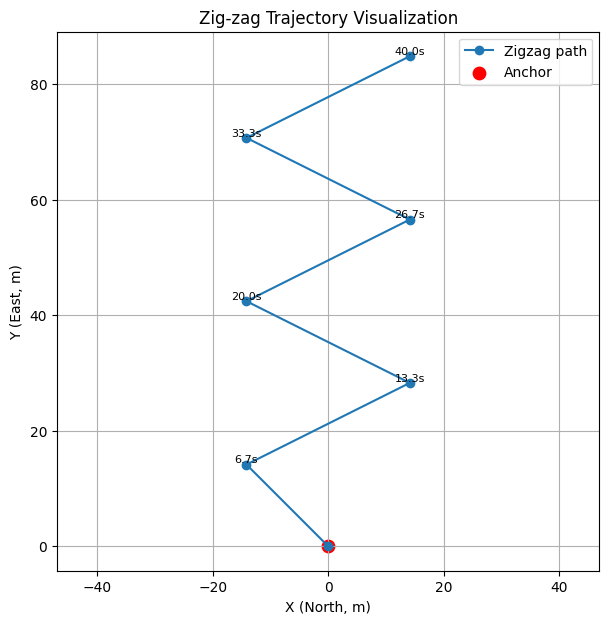

In [3]:


import matplotlib.pyplot as plt



def plot_zigzag(verts: List[PlanState], anchor: LocalNED, heading_deg: float):
    xs = [anchor.x] + [v.pos.x for v in verts]
    ys = [anchor.y] + [v.pos.y for v in verts]

    plt.figure(figsize=(7,7))
    plt.plot(xs, ys, 'o-', label='Zigzag path')
    plt.scatter(anchor.x, anchor.y, color='red', s=80, label='Anchor')

    # Draw reference heading arrow
    ref_len = max(3.0, 0.3 * len(verts))
    dx = ref_len * math.cos(math.radians(heading_deg))
    dy = ref_len * math.sin(math.radians(heading_deg))
    # plt.arrow(anchor.x, anchor.y, dx, dy, color='green', width=0.05,
    #           length_includes_head=True, label='Reference heading')

    for v in verts:
        plt.text(v.pos.x, v.pos.y, f"{v.t:.1f}s", fontsize=8, ha='center', va='bottom')

    plt.axis('equal')
    plt.xlabel('X (North, m)')
    plt.ylabel('Y (East, m)')
    plt.title('Zig-zag Trajectory Visualization')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- example run ---
if __name__ == "__main__":
    anchor = LocalNED(0, 0, -10)
    des_yaw_deg = 90  # TODO - make an arg
    des_speed_m_s = 3

    # Zigzag
    verts = generate_zigzag_vertices(
        anchor=anchor,
        heading_deg=des_yaw_deg,
        segment_length_m=20,
        num_segments=6,
        offset_angle_deg=45,
        speed_ms=des_speed_m_s,
    )

    plot_zigzag(verts, anchor, heading_deg=des_yaw_deg)